C:\Users\Adela\AppData\Local\Temp\ipykernel_27960\1766162548.py:46: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(train_X, train_Y)
C:\Users\Adela\anaconda3\envs\Bo-Torch_Basic\Lib\site-packages\botorch\models\utils\assorted.py:264: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\Adela\anaconda3\envs\Bo-Torch_Basic\Lib\site-packages\botorch\acquisition\analytic.py:331: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 ExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arx

ValueError: x and y can be no greater than 2D, but have shapes (200, 1, 1) and (200, 1, 1)

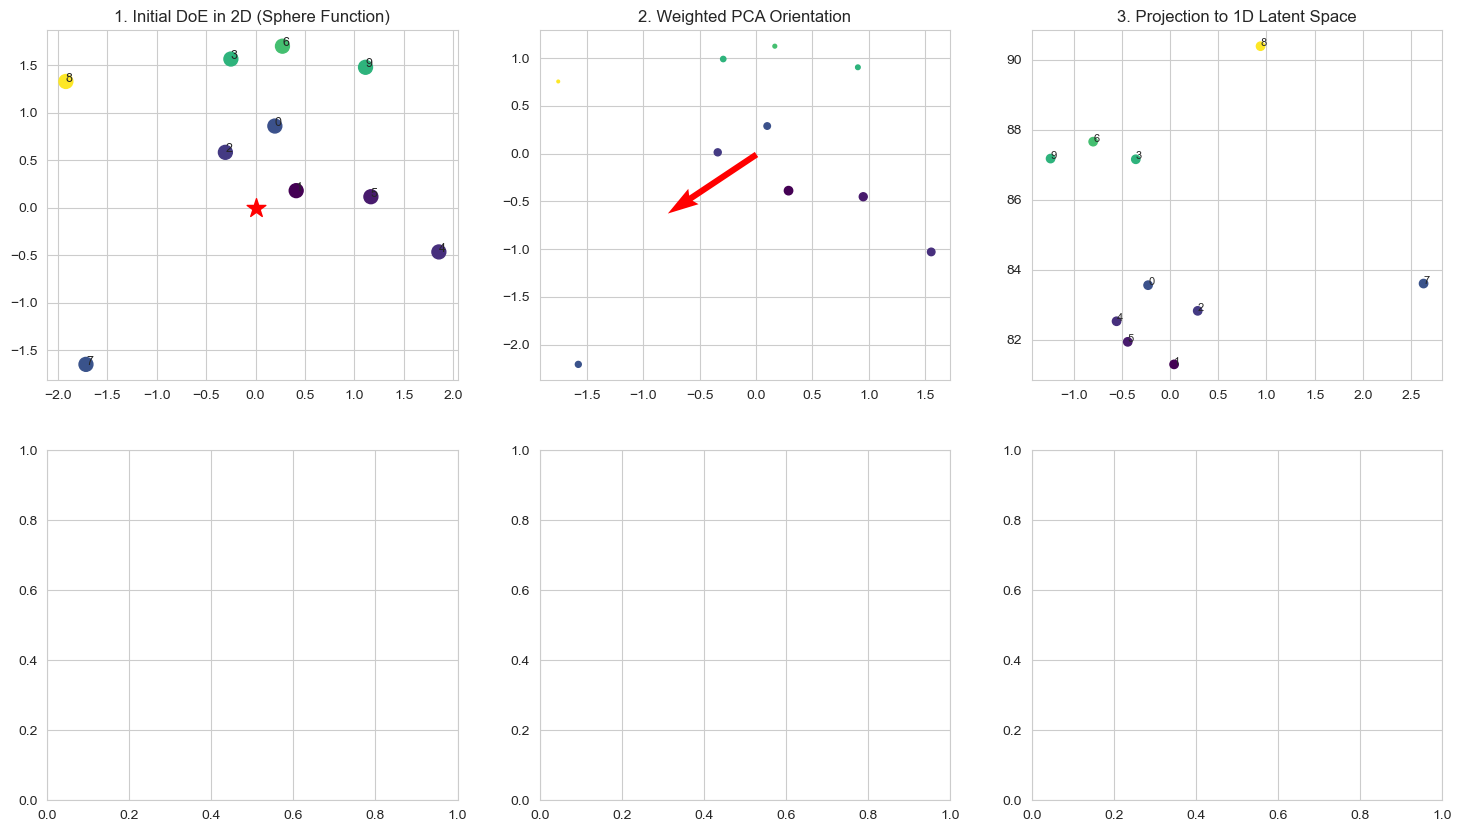

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from ioh import get_problem

from botorch.models import SingleTaskGP
from botorch import fit_gpytorch_mll
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood

# ---- 1. Initial Design of Experiments ---- #

# Create BBOB problem (Sphere function = f1, dim = 2, instance = 1)
bbob_problem = get_problem(1, dimension=2, instance=1)

# Generate random 2D samples
np.random.seed(0)
X_np = np.random.uniform(-2, 2, (10, 2))

# Evaluate using BBOB function (produces scalar)
y_np = np.array([[bbob_problem(x)] for x in X_np])


# ---- 2. Weighting ---- #
ranks = np.argsort(np.argsort(y_np.ravel()))
weights = (len(y_np) - ranks) / np.sum(len(y_np) - ranks)

# ---- 3. PCA (Weighted) ---- #
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np)
weighted_mean = np.average(X_scaled, axis=0, weights=weights)
X_centered = X_scaled - weighted_mean
weighted_cov = np.cov(X_centered.T, aweights=weights)
eigvals, eigvecs = np.linalg.eigh(weighted_cov)
pc1 = eigvecs[:, -1]  # Top principal component
X_proj_1d = (X_centered @ pc1).reshape(-1, 1)

# Convert to torch tensors for BoTorch
train_X = torch.tensor(X_proj_1d, dtype=torch.float32)
train_Y = torch.tensor(y_np, dtype=torch.float32)

# ---- 4. Train GP Model in 1D Latent Space ---- #
gp = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)

# ---- 5. Optimize Acquisition Function ---- #
ei = ExpectedImprovement(model=gp, best_f=train_Y.min())
bounds = torch.tensor([[train_X.min() - 1.0], [train_X.max() + 1.0]])
candidate, acq_value = optimize_acqf(
    acq_function=ei,
    bounds=bounds,
    q=1,
    num_restarts=5,
    raw_samples=50,
)

# ---- 6. Map Candidate Back to 2D ---- #
x_next_1d = candidate.detach().numpy().ravel()[0]
x_next_scaled = x_next_1d * pc1 + weighted_mean
x_next_original = scaler.inverse_transform(x_next_scaled.reshape(1, -1))

# ---- 🎨 Visualization ---- #
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# 1. Original DoE
axs[0, 0].scatter(X_np[:, 0], X_np[:, 1], c=y_np.ravel(), cmap="viridis", s=100)
axs[0, 0].set_title("1. Initial DoE in 2D (Sphere Function)")

# Mark the global optimum (0, 0) for Sphere function
axs[0, 0].scatter(0, 0, color='red', s=200, marker='*', label="Optimum (0, 0)")
for i, (x, label) in enumerate(zip(X_np, range(len(X_np)))):
    axs[0, 0].text(x[0], x[1], str(label), fontsize=9)

# 2. PCA Axes and Weighted Points
axs[0, 1].scatter(X_scaled[:, 0], X_scaled[:, 1], s=200 * weights, c=y_np.ravel(), cmap='viridis')
axs[0, 1].quiver(0, 0, *pc1, scale=1, scale_units='xy', angles='xy', color='red', width=0.015)
axs[0, 1].set_title("2. Weighted PCA Orientation")

# 3. Projection to 1D
axs[0, 2].scatter(X_proj_1d, y_np, c=y_np.ravel(), cmap="viridis")
axs[0, 2].set_title("3. Projection to 1D Latent Space")
for i, xi in enumerate(X_proj_1d):
    axs[0, 2].text(xi, y_np[i], str(i), fontsize=8)

# 4. GP Posterior and Acquisition Function
X_test = torch.linspace(bounds[0, 0], bounds[1, 0], 200).unsqueeze(-1).unsqueeze(1)
with torch.no_grad():
    posterior = gp.posterior(X_test)
    ei_vals = ei(X_test)

axs[1, 0].plot(X_test.numpy(), posterior.mean.numpy(), label="GP Mean")
axs[1, 0].fill_between(
    X_test.squeeze().numpy(),
    (posterior.mean - 2 * posterior.variance.sqrt()).squeeze().numpy(),
    (posterior.mean + 2 * posterior.variance.sqrt()).squeeze().numpy(),
    alpha=0.2,
    label="±2σ",
)
axs[1, 0].plot(X_test.numpy(), ei_vals.numpy(), 'r--', label="Expected Improvement")
axs[1, 0].axvline(x_next_1d, color='black', linestyle='--', label="Next Sample")
axs[1, 0].legend()
axs[1, 0].set_title("4. GP Posterior + EI in 1D Latent Space")

# 5. Back-Projection to 2D
axs[1, 1].scatter(X_np[:, 0], X_np[:, 1], c=y_np.ravel(), cmap="viridis")
axs[1, 1].scatter(x_next_original[0, 0], x_next_original[0, 1], marker='*', s=300, color='red', label="Next Point")
axs[1, 1].scatter(0, 0, color='red', s=200, marker='*', label="Optimum (0, 0)")  # Mark the optimum in 2D space
axs[1, 1].legend()
axs[1, 1].set_title("5. Back-Projection to 2D Search Space")

# 6. Empty placeholder
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()


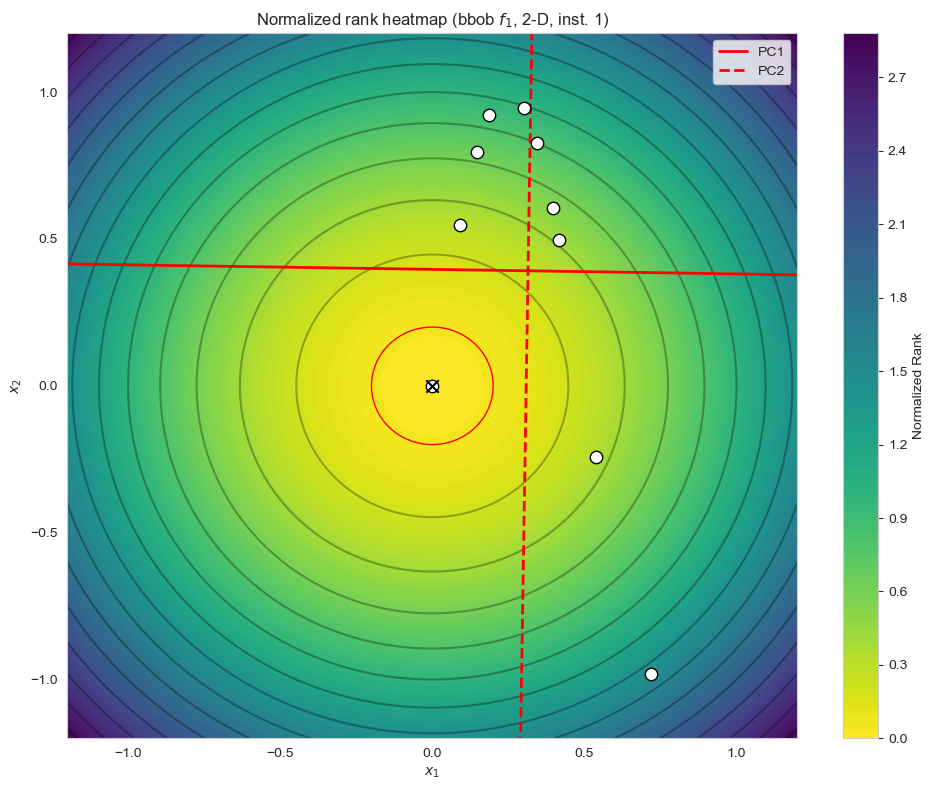

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as colors
from matplotlib.patches import Circle

# Load the data points from the CSV file
data = np.array([
    [1.143748173448866368e-04, 7.186381099970608980e-04],
    [9.233859476879779926e-02, 5.481749109919547003e-01],
    [1.467558908171130438e-01, 7.968687382785424322e-01],
    [1.862602113776709034e-01, 9.208704959976052873e-01],
    [3.023325726318397688e-01, 9.464255890012647221e-01],
    [3.455607270430477440e-01, 8.250951401358449511e-01],
    [3.967674742306699365e-01, 6.040944774579687371e-01],
    [4.170220047025740007e-01, 4.980652197092492739e-01],
    [5.388167340033569452e-01, -2.414819750403917609e-01],
    [7.203244934421580981e-01, -9.826672516685445169e-01]
])

X = data  # Initial sample points

# Define a 2D objective function (similar to the one in the image - spherical function)
def objective_function(x):
    return np.sum((x - np.array([0, 0]))**2, axis=1)

# Evaluate the objective function at the sample points
y = objective_function(X)

# Design a weighting scheme (higher weights for better points)
# Normalize function values inversely (lower is better)
weights = 1 / (y - y.min() + 0.1)
weights = weights / weights.sum()

# Apply PCA with weighted DoE
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create weighted samples for PCA
# Repeat each point according to its weight (approximation of weighted PCA)
weighted_indices = np.random.choice(
    range(len(X_scaled)),
    size=1000,
    p=weights/weights.sum(),
    replace=True
)
weighted_samples = X_scaled[weighted_indices]

# Apply PCA
pca = PCA(n_components=2)
pca.fit(weighted_samples)

# Create the visualization
plt.figure(figsize=(10, 8))

# Create a meshgrid for contour plotting
x = np.linspace(-1.2, 1.2, 100)  # Adjusted range to better fit the data
y = np.linspace(-1.2, 1.2, 100)
X_grid, Y_grid = np.meshgrid(x, y)
XY = np.column_stack([X_grid.ravel(), Y_grid.ravel()])
Z = objective_function(XY).reshape(X_grid.shape)

# Plot contour of the objective function
contour = plt.contour(X_grid, Y_grid, Z, levels=15, colors='black', alpha=0.3)
contourf = plt.contourf(X_grid, Y_grid, Z, levels=100, cmap='viridis_r')

# Plot the best point with a circle
best_idx = np.argmin(y)
plt.scatter([0], [0], color='black', marker='x', s=80, zorder=5)
circle = Circle((0, 0), 0.2, fill=False, color='red', linestyle='-')
plt.gca().add_patch(circle)

# Plot sample points
plt.scatter(X[:, 0], X[:, 1], color='white', edgecolor='black', s=80, zorder=4)

# Plot PCA directions
# Get the principal components
components = pca.components_
# Get the mean that was used for centering
mean = scaler.mean_

# Calculate endpoints for PCA vectors (scale them for visibility)
scale = 2  # Adjusted scale to fit the data range
pc1_endpoints = np.vstack([mean - scale * components[0], mean + scale * components[0]])
pc2_endpoints = np.vstack([mean - scale * components[1], mean + scale * components[1]])

# Plot the first principal component (solid line)
plt.plot(pc1_endpoints[:, 0], pc1_endpoints[:, 1], 'r-', linewidth=2, label='PC1')
# Plot the second principal component (dashed line)
plt.plot(pc2_endpoints[:, 0], pc2_endpoints[:, 1], 'r--', linewidth=2, label='PC2')

# Add labels and title
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Normalized rank heatmap (bbob $f_1$, 2-D, inst. 1)')
plt.colorbar(contourf, label='Normalized Rank')
plt.legend()
plt.grid(False)
plt.tight_layout()

# Add axis limits to better show the data
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)

plt.show()

In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pyDOE import lhs
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import imageio
import os


def save_animation(frames, filename, fps=2):
    """Save frames as an animated GIF"""
    if frames:
        imageio.mimsave(
            os.path.join('optimization_gifs', filename),
            frames,
            fps=fps
        )


class PCABO:
    def __init__(self, obj_function, dim, n_init_points=10, n_components=None, bounds=None):
        
        """
        Initialize PCA-BO optimizer

        Args:
            obj_function: The objective function to minimize
            dim: Original dimension of the problem
            n_init_points: Number of initial points for DoE
            n_components: Number of components to keep after PCA
            bounds: Bounds for optimization, tensor of shape (2, dim)
        """
        self.obj_function = obj_function
        self.dim = dim
        self.n_init_points = n_init_points
        self.n_components = n_components or max(1, dim // 2)

        if bounds is None:
            bounds = torch.stack([torch.zeros(dim), torch.ones(dim)])
        self.bounds = bounds

        self.X = None  # Design points
        self.y = None  # Objective values
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=self.n_components)

        self.visualization_data = {
            'iteration': [],
            'X_original': [],
            'X_reduced': [],
            'y': [],
            'weights': [],
            'acquisition_values': []
        }

        self.frames = {
            'initial_design': [],
            'weights': [],
            'pca': [],
            'acquisition': [],
            'progress': []
        }

        # Create output directory for GIFs if it doesn't exist
        os.makedirs('optimization_gifs', exist_ok=True)

    def generate_initial_design(self):
        """Step 1: Generate initial design using Latin Hypercube Sampling"""
        lhs_design = lhs(self.dim, samples=self.n_init_points)
        # Scale to bounds
        X = self.bounds[0] + (self.bounds[1] - self.bounds[0]) * torch.tensor(lhs_design)
        y = torch.tensor([self.obj_function(x) for x in X])

        self.X = X
        self.y = y.reshape(-1, 1)

    def compute_weights(self):
        """Step 2: Compute weights based on function values"""
        # Use rank-based weights
        ranks = stats.rankdata(-self.y.numpy().flatten())  # Negative for minimization
        weights = ranks / np.sum(ranks)
        return torch.tensor(weights)

    def apply_weighted_pca(self, weights):
        """Step 3: Apply PCA with weighted points"""
        # Scale the data
        X_scaled = self.scaler.fit_transform(self.X)

        # Apply weights
        X_weighted = torch.from_numpy(X_scaled) * weights.reshape(-1, 1)

        # Fit PCA
        self.pca.fit(X_weighted)
        return self.pca.transform(X_scaled)
    def optimize_acquisition(self, X_reduced, y):
        """Step 4: Perform Bayesian optimization in reduced space"""
        X_torch = torch.tensor(X_reduced, dtype=torch.float32)
        y_torch = torch.tensor(y, dtype=torch.float32)

        # Initialize GP model
        model = SingleTaskGP(X_torch, y_torch)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)

        # Define acquisition function
        EI = ExpectedImprovement(model, best_f=y_torch.min())

        # Create a grid of test points for visualization
        if self.n_components == 1:
            test_x = np.linspace(-3, 3, 100).reshape(-1, 1)
        else:
            # For 2D, create a grid
            x = np.linspace(-3, 3, 20)
            y = np.linspace(-3, 3, 20)
            xx, yy = np.meshgrid(x, y)
            test_x = np.column_stack((xx.ravel(), yy.ravel()))

        test_points = torch.tensor(test_x, dtype=torch.float32)

        # Store both test points and their acquisition values
        with torch.no_grad():
            self.test_points = test_points
            self.last_acquisition_values = EI(test_points.unsqueeze(-2)).numpy()

        # Optimize acquisition function
        bounds_reduced = torch.stack([
            torch.ones(self.n_components) * -3,  # Approximate bounds in PCA space
            torch.ones(self.n_components) * 3
        ])

        new_point, _ = optimize_acqf(
            acq_function=EI,
            bounds=bounds_reduced,
            q=1,
            num_restarts=5,
            raw_samples=20,
        )

        return new_point

    def inverse_transform(self, X_reduced):
        """Step 5: Map point back to original space"""
        X_scaled = self.pca.inverse_transform(X_reduced)
        return torch.tensor(self.scaler.inverse_transform(X_scaled))

    def visualize_initial_design(self):
        """Visualize the initial design points and save frame"""
        plt.figure(figsize=(10, 6))

        if self.dim <= 3:
            if self.dim == 2:
                plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y.flatten(), cmap='viridis')
                plt.colorbar(label='Objective Value')
                plt.xlabel('X1')
                plt.ylabel('X2')
            elif self.dim == 3:
                ax = plt.axes(projection='3d')
                scatter = ax.scatter(self.X[:, 0], self.X[:, 1], self.X[:, 2],
                                     c=self.y.flatten(), cmap='viridis')
                plt.colorbar(scatter, label='Objective Value')
                ax.set_xlabel('X1')
                ax.set_ylabel('X2')
                ax.set_zlabel('X3')
        else:
            pd.plotting.parallel_coordinates(
                pd.DataFrame(np.hstack([self.X, self.y]),
                             columns=[f'X{i + 1}' for i in range(self.dim)] + ['y']),
                'y', colormap=plt.cm.viridis)

        plt.title('Initial Design Points')

        # Save frame
        fig = plt.gcf()
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_argb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        self.frames['initial_design'].append(image)
        plt.close()

    def visualize_weights(self, weights, iteration):
        """Visualize the weights assigned to points and save frame"""
        plt.figure(figsize=(10, 6))
        plt.scatter(range(len(weights)), weights, alpha=0.6)
        plt.plot(range(len(weights)), weights, 'r--', alpha=0.3)
        plt.xlabel('Point Index')
        plt.ylabel('Weight')
        plt.title(f'Weights Distribution (Iteration {iteration})')

        # Save frame
        fig = plt.gcf()
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_argb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        self.frames['weights'].append(image)
        plt.close()

    def visualize_pca_components(self, X_reduced):
        """Visualize PCA components and explained variance"""
        # Plot explained variance ratio
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.bar(range(1, len(self.pca.explained_variance_ratio_) + 1),
                self.pca.explained_variance_ratio_)
        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.title('Explained Variance by Components')

        # Plot first two components if available
        if X_reduced.shape[1] >= 2:
            plt.subplot(1, 2, 2)
            plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=self.y.flatten(), cmap='viridis')
            plt.colorbar(label='Objective Value')
            plt.xlabel('PC1')
            plt.ylabel('PC2')
            plt.title('First Two Principal Components')

        plt.tight_layout()
        plt.show()

    def visualize_acquisition(self, X_reduced, acq_values, iteration):
        """Visualize acquisition function and save frame"""
        if not hasattr(self, 'test_points'):
            return

        plt.figure(figsize=(10, 6))
        if self.n_components == 1:
            plt.scatter(X_reduced.flatten(), np.zeros_like(X_reduced.flatten()),
                        c='red', label='Observed points', alpha=0.6)
            plt.plot(self.test_points.numpy(), acq_values, 'b-', label='Acquisition function')
            plt.xlabel('Reduced Dimension')
            plt.ylabel('Acquisition Value')
        else:
            test_x = self.test_points.numpy()
            plt.tricontourf(test_x[:, 0], test_x[:, 1], acq_values.flatten())
            plt.colorbar(label='Acquisition Value')
            plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c='red',
                        label='Observed points', alpha=0.6)
            plt.xlabel('PC1')
            plt.ylabel('PC2')

        plt.title(f'Acquisition Function Values (Iteration {iteration})')
        plt.legend()

        # Save frame
        fig = plt.gcf()
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_argb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        self.frames['acquisition'].append(image)
        plt.close()

    def visualize_optimization_progress(self, iteration):
        """Visualize optimization progress and save frame"""
        plt.figure(figsize=(15, 5))

        # Plot best value so far
        plt.subplot(1, 2, 1)
        best_so_far = np.minimum.accumulate(self.y.numpy().flatten())
        plt.plot(range(len(best_so_far)), best_so_far, 'b-', label='Best Value')
        plt.xlabel('Iteration')
        plt.ylabel('Best Objective Value')
        plt.title(f'Optimization Progress (Iteration {iteration})')
        plt.legend()

        # Plot all evaluated points
        plt.subplot(1, 2, 2)
        plt.scatter(range(len(self.y)), self.y.numpy().flatten(), alpha=0.6)
        plt.xlabel('Iteration')
        plt.ylabel('Objective Value')
        plt.title('All Evaluated Points')

        plt.tight_layout()

        # Save frame
        fig = plt.gcf()
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_argb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        self.frames['progress'].append(image)
        plt.close()

    def optimize(self, n_iterations=50):
        """Main optimization loop with visualization"""
        self.generate_initial_design()
        self.visualize_initial_design()

        best_value = float('inf')
        best_point = None

        for i in range(n_iterations):
            weights = self.compute_weights()
            self.visualize_weights(weights, i)

            X_reduced = self.apply_weighted_pca(weights)

            new_point_reduced = self.optimize_acquisition(X_reduced, self.y)

            if hasattr(self, 'last_acquisition_values'):
                self.visualize_acquisition(X_reduced, self.last_acquisition_values, i)

            new_point = self.inverse_transform(new_point_reduced.numpy())
            new_value = self.obj_function(new_point.squeeze())

            self.X = torch.vstack((self.X, new_point))
            self.y = torch.vstack((self.y, torch.tensor([[new_value]])))

            if new_value < best_value:
                best_value = new_value
                best_point = new_point

            self.visualize_optimization_progress(i)

        # Save all animations
        save_animation(self.frames['initial_design'], 'initial_design.gif')
        save_animation(self.frames['weights'], 'weights.gif')
        save_animation(self.frames['acquisition'], 'acquisition.gif')
        save_animation(self.frames['progress'], 'optimization_progress.gif')

        return best_point, best_value


# Example usage with a more interesting 2D function for better visualization
def example_objective_2d(x):
    """2D objective function (Rastrigin function)"""
    x = x.numpy() if isinstance(x, torch.Tensor) else x
    return 20 + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))

# Initialize and run optimization with visualization
optimizer = PCABO(
    obj_function=example_objective_2d,
    dim=2,  # 2D problem for better visualization
    n_init_points=10,
    n_components=1  # Reduce to 1 dimension
)

best_point, best_value = optimizer.optimize(n_iterations=30)
print(f"Best point found: {best_point}")
print(f"Best value found: {best_value}")

C:\Users\Adela\AppData\Local\Temp\ipykernel_11316\1422626232.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_torch = torch.tensor(y, dtype=torch.float32)
C:\Users\Adela\AppData\Local\Temp\ipykernel_11316\1422626232.py:110: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(X_torch, y_torch)
C:\Users\Adela\anaconda3\envs\Bo-Torch_Basic\Lib\site-packages\botorch\models\utils\assorted.py:264: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\Adela\anaconda3\envs\Bo-Torch_Basic\Lib\site-packages\

KeyboardInterrupt: 